Purpose:
Use engineered features to analyse churn risk and produce actionable business insights.

In [2]:
import pandas as pd


df = pd.read_csv("../../data/featured_telco_churn.csv")


df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,high_monthly_charge,num_services
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-6,0,1
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,56.95,1889.50,0,24+,0,2
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-6,0,2
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,24+,0,3
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-6,1,0


In [3]:
df.shape

(7032, 24)

In [4]:
df.dtypes

customerID                 str
gender                     str
SeniorCitizen            int64
Partner                    str
Dependents                 str
tenure                   int64
PhoneService               str
MultipleLines              str
InternetService            str
OnlineSecurity             str
OnlineBackup               str
DeviceProtection           str
TechSupport                str
StreamingTV                str
StreamingMovies            str
Contract                   str
PaperlessBilling           str
PaymentMethod              str
MonthlyCharges         float64
TotalCharges           float64
Churn                    int64
tenure_group               str
high_monthly_charge      int64
num_services             int64
dtype: object

In [5]:
df['Churn'].mean()

np.float64(0.26578498293515357)

About 1 in 4 customers churn, so predicting churn is non-trivial but meaningful.

In [6]:
df.groupby('Contract')['Churn'].mean().sort_values(ascending=False)

Contract
Month-to-month    0.427097
One year          0.112772
Two year          0.028487
Name: Churn, dtype: float64

Contract length is one of the strongest predictors of churn.

In [7]:
df.groupby('tenure_group')['Churn'].mean()

tenure_group
0-6      0.533333
12-24    0.287109
24+      0.183430
6-12     0.358865
Name: Churn, dtype: float64

New customers churn far more → onboarding & early retention are critical.

In [8]:
df.groupby('high_monthly_charge')['Churn'].mean()

high_monthly_charge
0    0.179596
1    0.352121
Name: Churn, dtype: float64

High-paying customers are more likely to churn → pricing sensitivity.

In [9]:
df.groupby('num_services')['Churn'].mean()

num_services
0    0.214641
1    0.457557
2    0.358180
3    0.273948
4    0.223529
5    0.124780
6    0.052817
Name: Churn, dtype: float64

Customers with more services are “stickier” and churn less.

In [10]:
summary = {
    'Overall churn': df['Churn'].mean(),
    'Month-to-month churn': df[df['Contract'] == 'Month-to-month']['Churn'].mean(),
    'Two-year churn': df[df['Contract'] == 'Two year']['Churn'].mean(),
    '0-6 month churn': df[df['tenure_group'] == '0-6']['Churn'].mean(),
    'High charge churn': df[df['high_monthly_charge'] == 1]['Churn'].mean()
}

pd.Series(summary)

Overall churn           0.265785
Month-to-month churn    0.427097
Two-year churn          0.028487
0-6 month churn         0.533333
High charge churn       0.352121
dtype: float64

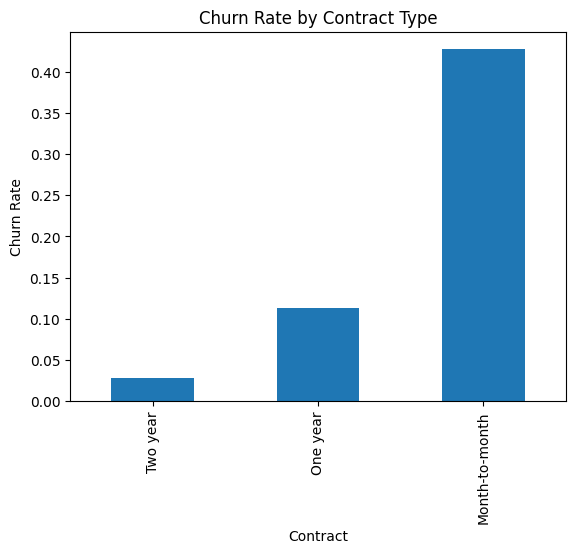

In [11]:
import matplotlib.pyplot as plt

contract_churn = df.groupby('Contract')['Churn'].mean().sort_values()

plt.figure()
contract_churn.plot(kind='bar')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Contract Type')
plt.show()

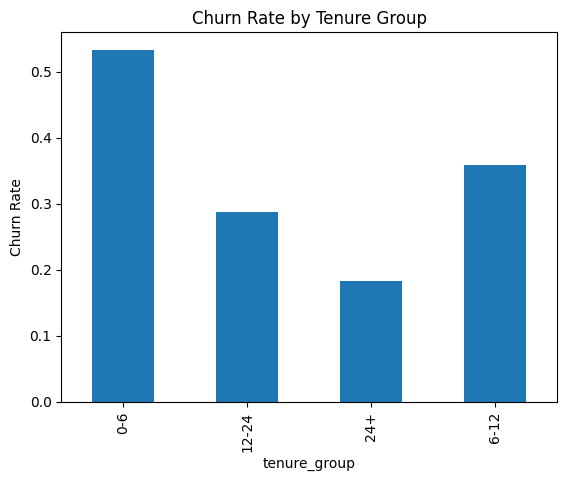

In [12]:
tenure_churn = df.groupby('tenure_group')['Churn'].mean()

plt.figure()
tenure_churn.plot(kind='bar')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Tenure Group')
plt.show()

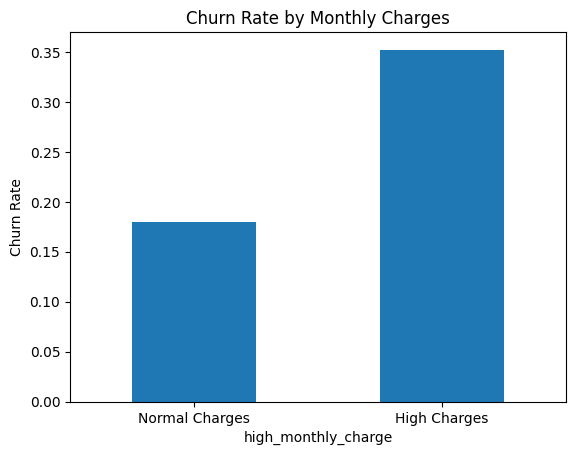

In [13]:
charge_churn = df.groupby('high_monthly_charge')['Churn'].mean()

plt.figure()
charge_churn.plot(kind='bar')
plt.ylabel('Churn Rate')
plt.xticks([0, 1], ['Normal Charges', 'High Charges'], rotation=0)
plt.title('Churn Rate by Monthly Charges')
plt.show()

In [14]:
features = [
    'Contract',
    'tenure_group',
    'high_monthly_charge',
    'num_services'
]

X = df[features]
y = df['Churn']

In [15]:
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.head()

,high_monthly_charge,num_services,Contract_One year,Contract_Two year,tenure_group_12-24,tenure_group_24+,tenure_group_6-12
0,0,1,False,False,False,False,False
1,0,2,True,False,False,True,False
2,0,2,False,False,False,False,False
3,0,3,True,False,False,True,False
4,1,0,False,False,False,False,False


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [17]:
model.score(X_test, y_test)

0.7711442786069652

In [18]:
coefficients = pd.Series(
    model.coef_[0],
    index=X_encoded.columns
).sort_values()

coefficients

Contract_Two year     -3.313833
Contract_One year     -1.718303
tenure_group_24+      -0.883108
tenure_group_12-24    -0.768591
tenure_group_6-12     -0.427206
num_services          -0.047690
high_monthly_charge    1.223620
dtype: float64

I built a churn prediction model (logistic regression, ~77% accuracy) and found contract type and tenure were the strongest predictors. Month-to-month customers were dramatically more likely to churn, while two-year contracts reduced churn the most. High monthly charges significantly increased churn risk, suggesting price sensitivity among premium customers.